In [1]:
import pandas as pd  
from tqdm import tqdm  
from collections import defaultdict  
import numpy as np
import math  
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

Pretty printing has been turned OFF


In [2]:
train_path = '../data/underexpose_train'  
test_path = '../data/underexpose_test'
train_path_click=train_path+'/underexpose_train_click-{}.csv'
test_path_click=test_path+'/underexpose_test_click-{0}/underexpose_test_click-{0}.csv'
test_path_click_qtime=test_path+'/underexpose_test_click-{0}/underexpose_test_qtime-{0}.csv'
train_path_item=train_path+'/underexpose_item_feat.csv'
train_path_user=train_path+'/underexpose_user_feat.csv'

# 获取数据

## 获取训练特征

In [3]:
def getTrainData(files,isckick=True,names=['user_id', 'item_id', 'time'],num=1):
    """
    
    :param files: 文件路径
    :param num:读取文件个数 
    :return: 
    """

    all_train = pd.DataFrame( columns=names)  
    if isckick:
        for p in range(num):
            print(p)
            dt=pd.read_csv(files.format(p), header=None,  names=names)
            all_train = pd.concat([all_train, dt])
            del dt
    else:
         all_train=pd.read_csv(files, header=None,  names=names)
    return all_train  

### 获取train_click

In [4]:
train_click_data=getTrainData(train_path_click,isckick=True,names=['user_id', 'item_id', 'time'],num=7)

0
1
2
3
4
5
6


In [5]:
train_click_data.head()
train_click_data.info()
train_click_data.describe()
train_click_data.shape

,user_id,item_id,time
0,4965,18,0.983763
1,20192,34,0.983772
2,30128,91,0.983780
3,29473,189,0.983930
4,10625,225,0.983925


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1856637 entries, 0 to 310371
Data columns (total 3 columns):
user_id    object
item_id    object
time       float64
dtypes: float64(1), object(2)
memory usage: 56.7+ MB


,time
count,1.856637e+06
mean,9.840335e-01
std,1.264442e-04
min,9.837397e-01
25%,9.839386e-01
50%,9.840467e-01
75%,9.841189e-01
max,9.842848e-01


(1856637, 3)

#### 去重

In [6]:
train_click_data=train_click_data.drop_duplicates()

In [7]:
train_click_data.shape

(1139080, 3)

In [8]:
train_click_data.head()

,user_id,item_id,time
0,4965,18,0.983763
1,20192,34,0.983772
2,30128,91,0.983780
3,29473,189,0.983930
4,10625,225,0.983925


### user_id个数

In [9]:
train_click_userid=train_click_data["user_id"].drop_duplicates().to_frame()

In [10]:
#train_click_userid["user_id"]=train_click_userid["user_id"].apply(lambda x : str(x))
train_click_userid.shape[0]
train_click_userid.head()
train_click_userid.info()

31049

,user_id
0,4965
1,20192
2,30128
3,29473
4,10625


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31049 entries, 0 to 291149
Data columns (total 1 columns):
user_id    31049 non-null object
dtypes: object(1)
memory usage: 485.1+ KB


### 排序

In [11]:
train_click_userid=train_click_userid.sort_values(by=['user_id'],axis=0,ascending=True)

In [12]:
train_click_userid.head()

,user_id
3123,1
475,2
10140,3
8145,4
36979,5


#### 用户出现次数

In [24]:
train_click_groupby_userid=train_click_data["user_id"].value_counts().to_frame().reset_index()

train_click_groupby_userid.columns=["user_id","user_id_count"]
train_click_groupby_userid.head()
train_click_groupby_userid.shape

,user_id,user_id_count
0,8330,542
1,32578,526
2,12627,506
3,32549,505
4,35363,502


(31049, 2)

### 显示用户出现点击次数最多的前五个和最好的五个

In [39]:
train_click_groupby_userid_tail100= train_click_groupby_userid.tail(10000)
train_click_groupby_userid_tail100=train_click_groupby_userid_tail100.drop_duplicates("user_id_count")
train_click_groupby_userid_tail100.tail()

,user_id,user_id_count
27044,757,6
28011,26558,5
28908,9325,4
29879,6678,3
30959,21983,2


In [40]:
user_id_count=pd.concat([train_click_groupby_userid.head(),train_click_groupby_userid_tail100.tail()])
user_id_count

,user_id,user_id_count
0,8330,542
1,32578,526
2,12627,506
3,32549,505
4,35363,502
27044,757,6
28011,26558,5
28908,9325,4
29879,6678,3
30959,21983,2


### 对用户显示点击次数进行画图

In [41]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.-0.2, 1.03*height, '%s' % float(height))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'User_ID_COUNT')

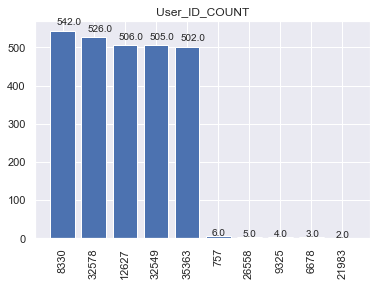

In [42]:
a=plt.bar(  range(len(user_id_count.index)),user_id_count["user_id_count"].values ,
          width=0.8,tick_label = user_id_count["user_id"])
autolabel(a)
plt.xticks(rotation = 90)
plt.title('User_ID_COUNT')
plt.show()

### 商品出现次数分析

In [43]:
train_click_groupby_item_id=train_click_data["item_id"].value_counts().to_frame().reset_index()

train_click_groupby_item_id.columns=["item_id","item_id_count"]
train_click_groupby_item_id.shape[0]
train_click_groupby_item_id=train_click_groupby_item_id.sort_values(axis = 0,by=["item_id_count"],ascending=False)


98764

In [49]:
train_click_groupby_item_id.head()

,item_id,item_id_count
0,52766,947
1,12845,617
2,111225,610
3,4340,603
4,13302,523


### 可以看出大量物品只出现很少次数

In [55]:
train_click_groupby_item_id_tail100= train_click_groupby_item_id.tail(40000)
train_click_groupby_item_id_tail100=train_click_groupby_item_id_tail100.drop_duplicates("item_id_count")
train_click_groupby_item_id_tail100.tail()

,item_id,item_id_count
65658,66936,5
82779,56055,4
94815,80762,3
98211,94736,2
98727,77456,1


In [56]:
item_id_count=pd.concat([train_click_groupby_item_id.head(),train_click_groupby_item_id_tail100.tail()])

In [57]:
train_click_groupby_item_id[["item_id_count"]].describe()

,item_id_count
count,98764.000000
mean,11.533352
std,16.561612
min,1.000000
25%,4.000000
50%,7.000000
75%,13.000000
max,947.000000


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

Text(0.5, 1.0, 'ITEM_ID_COUNT')

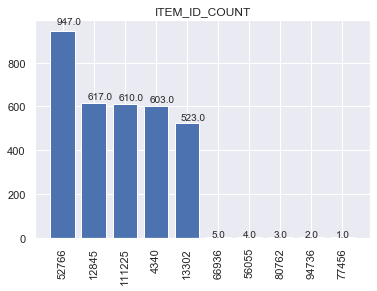

In [59]:
b=plt.bar(  range(len(item_id_count.index)),item_id_count["item_id_count"].values ,
          width=0.8,tick_label = item_id_count["item_id"])
autolabel(b)
plt.xticks(rotation = 90)
plt.title('ITEM_ID_COUNT')
plt.show()


### 加入时间  

In [60]:
"""
思考这样去截取时间有没有意义？
如果有意义：应该对时间戳分别截取多长进行划分不同等级？
"""

'\n思考这样去截取时间有没有意义？\n如果有意义：应该对时间戳分别截取多长进行划分不同等级？\n'

In [61]:
"""
截取时间的位数相当于按照不同的区间对时间进行了区间划分
"""

'\n截取时间的位数相当于按照不同的区间对时间进行了区间划分\n'

In [71]:
substrn=16

In [74]:
for i in range(5,substrn):
    col="time_top_{0}".format(i)
    train_click_data[col]=train_click_data['time'].apply(lambda x:str(x)[:i])

In [75]:
train_click_data.columns

Index(['user_id', 'item_id', 'time', 'time_top_5', 'time_top_6', 'time_top_7',
       'time_top_8', 'time_top_9', 'time_top_10', 'time_top_11', 'time_top_12',
       'time_top_13', 'time_top_14', 'time_top_15'],
      dtype='object')

In [76]:
train_click_data=train_click_data.sort_values(axis=0,by=['user_id', 'time_top_5', 'time_top_6', 'time_top_7',
       'time_top_8', 'time_top_9', 'time_top_10', 'time_top_11', 'time_top_12',
       'time_top_13', 'time_top_14', 'time_top_15'],ascending=True)

#### 用户在某一时间戳下发生点击次数

In [77]:
train_click=train_click_data
for i in range(5,substrn):
    col="time_top_{0}".format(i)
    test_click_n=train_click.groupby(['user_id', col]).size().reset_index()
    col_count=col+"_user_clickcount"
    test_click_n.rename(columns={0: col_count}, inplace=True)
    train_click= pd.merge(train_click, test_click_n, how='left', on=['user_id', col])
train_click.head()

,user_id,item_id,time,time_top_5,time_top_6,time_top_7,time_top_8,time_top_9,time_top_10,time_top_11,...,time_top_6_user_clickcount,time_top_7_user_clickcount,time_top_8_user_clickcount,time_top_9_user_clickcount,time_top_10_user_clickcount,time_top_11_user_clickcount,time_top_12_user_clickcount,time_top_13_user_clickcount,time_top_14_user_clickcount,time_top_15_user_clickcount
0,1,78142,0.983742,0.983,0.9837,0.98374,0.983741,0.9837416,0.98374161,0.983741619,...,6,1,1,1,1,1,1,1,1,1
1,1,26646,0.983757,0.983,0.9837,0.98375,0.983756,0.9837566,0.98375665,0.983756656,...,6,1,1,1,1,1,1,1,1,1
2,1,89568,0.983763,0.983,0.9837,0.98376,0.983763,0.9837634,0.98376343,0.983763437,...,6,1,1,1,1,1,1,1,1,1
3,1,76240,0.983770,0.983,0.9837,0.98377,0.983770,0.9837704,0.98377043,0.983770432,...,6,1,1,1,1,1,1,1,1,1
4,1,87533,0.983790,0.983,0.9837,0.98378,0.983789,0.9837895,0.98378950,0.983789507,...,6,2,2,2,1,1,1,1,1,1


In [84]:
train_click.columns


Index(['user_id', 'item_id', 'time', 'time_top_5', 'time_top_6', 'time_top_7',
       'time_top_8', 'time_top_9', 'time_top_10', 'time_top_11', 'time_top_12',
       'time_top_13', 'time_top_14', 'time_top_15',
       'time_top_5_user_clickcount', 'time_top_6_user_clickcount',
       'time_top_7_user_clickcount', 'time_top_8_user_clickcount',
       'time_top_9_user_clickcount', 'time_top_10_user_clickcount',
       'time_top_11_user_clickcount', 'time_top_12_user_clickcount',
       'time_top_13_user_clickcount', 'time_top_14_user_clickcount',
       'time_top_15_user_clickcount', 'time_top_5_item_clickcount',
       'time_top_6_item_clickcount', 'time_top_7_item_clickcount',
       'time_top_8_item_clickcount', 'time_top_9_item_clickcount',
       'time_top_10_item_clickcount', 'time_top_11_item_clickcount',
       'time_top_12_item_clickcount', 'time_top_13_item_clickcount',
       'time_top_14_item_clickcount', 'time_top_15_item_clickcount'],
      dtype='object')

#### 商品在某一时间戳下发生点击次数

In [80]:
for i in range(5,substrn):
    col="time_top_{0}".format(i)
    test_click_n=train_click.groupby(['item_id', col]).size().reset_index()
    col_count=col+"_item_clickcount"
    test_click_n.rename(columns={0: col_count}, inplace=True)
    train_click= pd.merge(train_click, test_click_n, how='left', on=['item_id', col])
train_click.head()

,user_id,item_id,time,time_top_5,time_top_6,time_top_7,time_top_8,time_top_9,time_top_10,time_top_11,...,time_top_6_item_clickcount,time_top_7_item_clickcount,time_top_8_item_clickcount,time_top_9_item_clickcount,time_top_10_item_clickcount,time_top_11_item_clickcount,time_top_12_item_clickcount,time_top_13_item_clickcount,time_top_14_item_clickcount,time_top_15_item_clickcount
0,1,78142,0.983742,0.983,0.9837,0.98374,0.983741,0.9837416,0.98374161,0.983741619,...,1,1,1,1,1,1,1,1,1,1
1,1,26646,0.983757,0.983,0.9837,0.98375,0.983756,0.9837566,0.98375665,0.983756656,...,1,1,1,1,1,1,1,1,1,1
2,1,89568,0.983763,0.983,0.9837,0.98376,0.983763,0.9837634,0.98376343,0.983763437,...,3,2,1,1,1,1,1,1,1,1
3,1,76240,0.983770,0.983,0.9837,0.98377,0.983770,0.9837704,0.98377043,0.983770432,...,1,1,1,1,1,1,1,1,1,1
4,1,87533,0.983790,0.983,0.9837,0.98378,0.983789,0.9837895,0.98378950,0.983789507,...,1,1,1,1,1,1,1,1,1,1


In [85]:
train_click.columns

Index(['user_id', 'item_id', 'time', 'time_top_5', 'time_top_6', 'time_top_7',
       'time_top_8', 'time_top_9', 'time_top_10', 'time_top_11', 'time_top_12',
       'time_top_13', 'time_top_14', 'time_top_15',
       'time_top_5_user_clickcount', 'time_top_6_user_clickcount',
       'time_top_7_user_clickcount', 'time_top_8_user_clickcount',
       'time_top_9_user_clickcount', 'time_top_10_user_clickcount',
       'time_top_11_user_clickcount', 'time_top_12_user_clickcount',
       'time_top_13_user_clickcount', 'time_top_14_user_clickcount',
       'time_top_15_user_clickcount', 'time_top_5_item_clickcount',
       'time_top_6_item_clickcount', 'time_top_7_item_clickcount',
       'time_top_8_item_clickcount', 'time_top_9_item_clickcount',
       'time_top_10_item_clickcount', 'time_top_11_item_clickcount',
       'time_top_12_item_clickcount', 'time_top_13_item_clickcount',
       'time_top_14_item_clickcount', 'time_top_15_item_clickcount'],
      dtype='object')

### 按照不同时间区间查看商品点击次数的总和

### 找出小数点后三位不同区间

In [90]:
top5=train_click["time_top_5"].drop_duplicates()


In [92]:
train_click_item_top5=train_click[["item_id","time_top_5"]]

In [94]:
train_click_item_top5.shape
train_click_item_top5.head()

(1139080, 2)

,item_id,time_top_5
0,78142,0.983
1,26646,0.983
2,89568,0.983
3,76240,0.983
4,87533,0.983


In [109]:
train_click_item_top5_count=train_click_item_top5["time_top_5"].value_counts().reset_index()


train_click_item_top5_count.rename(columns={'index': 'item_5','time_top_5':'click_count'}, inplace=True)


In [111]:
train_click_item_top5_count.head()

,item_5,click_count
0,0.984,578907
1,0.983,560173


(array([0, 1]), <a list of 2 Text xticklabel objects>)

Text(0.5, 1.0, 'Click_COUNT')

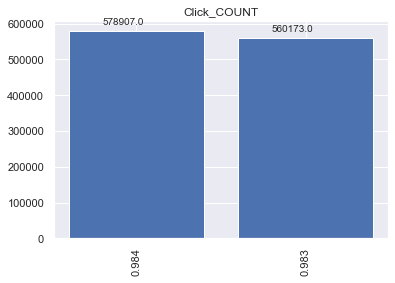

In [120]:
click_count_fig=plt.bar(  range(len(train_click_item_top5_count.item_5)),train_click_item_top5_count["click_count"].values ,
          width=0.8,tick_label = train_click_item_top5_count["item_5"])
autolabel(click_count_fig)
plt.xticks(rotation = 90)
plt.title('Click_COUNT')
plt.show()


###  找出小数点后4位不同区间

In [116]:
def plotcount(train_click_item_count,time_top_n,click_count_n,n):
    click_count_fig=plt.bar(  range(len(train_click_item_count[time_top_n])),train_click_item_count[click_count_n].values ,
          width=0.8,tick_label = train_click_item_count[time_top_n])
    autolabel(click_count_fig)
    plt.xticks(rotation = 90)
    plt.title('Click_COUNT_{}'.format(n))
    plt.show()

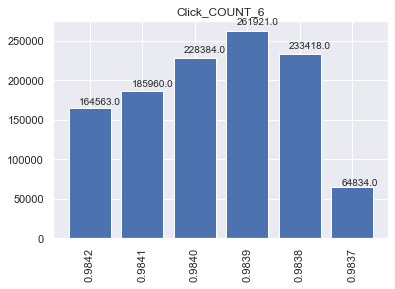

In [123]:
top6=train_click["time_top_6"].drop_duplicates()
train_click_item_top6=train_click[["item_id","time_top_6"]]
train_click_item_top6_count=train_click_item_top6["time_top_6"].value_counts().reset_index()
train_click_item_top6_count.rename(columns={'index': 'item_6','time_top_6':'click_count6'}, inplace=True)
train_click_item_top6_count=train_click_item_top6_count.sort_values(axis=0,by=["item_6"],ascending=False)
plotcount(train_click_item_top6_count,"item_6","click_count6",6)

### 找出小数点后4位不同区间

In [132]:
def get_item_top_n(n):
    col="time_top_{0}".format(n)
    train_click_item_top=train_click[["item_id",col]]
    train_click_item_top_count=train_click_item_top[col].value_counts().reset_index()
    train_click_item_top_count.rename(columns={'index': 'item_{}'.format(n),col:'click_count{}'.format(n)}, inplace=True)
    train_click_item_top_count=train_click_item_top_count.sort_values(axis=0,by=[ 'item_{}'.format(n)],ascending=False)
    return train_click_item_top_count

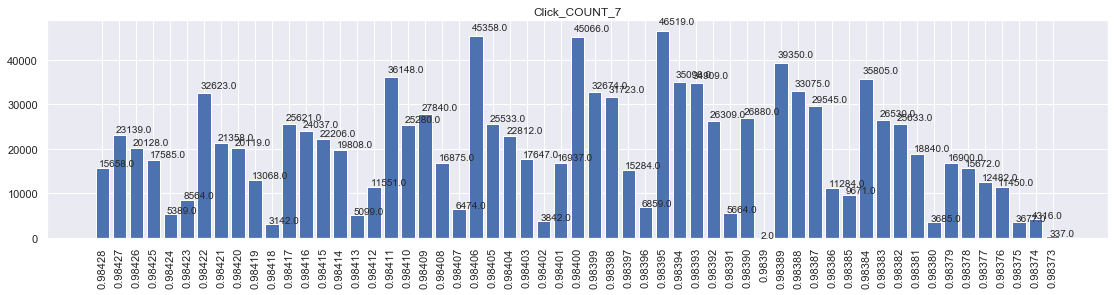

In [140]:

train_click_item_top7_count=get_item_top_n(7)
plotcount(train_click_item_top7_count,"item_{0}".format(7),"click_count{}".format(7),7)

plt.rcParams['figure.figsize'] = (39.0, 4.0) # 设置figure_size尺寸

In [149]:



col="time_top_{0}".format(7)
train_click_item_top=train_click[["item_id",col]]
train_click_item_top.head()
train_click_item_top.info()

,item_id,time_top_7
0,78142,0.98374
1,26646,0.98375
2,89568,0.98376
3,76240,0.98377
4,87533,0.98378


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1139080 entries, 0 to 1139079
Data columns (total 2 columns):
item_id       1139080 non-null object
time_top_7    1139080 non-null object
dtypes: object(2)
memory usage: 26.1+ MB


In [152]:


app=[]

for i in range(98370,98430,10):
    app.append(i/100000)
app

[0.9837, 0.9838, 0.9839, 0.984, 0.9841, 0.9842]

In [157]:
train_click_item_top["time_top_7"]=train_click_item_top["time_top_7"].apply(lambda x:float('%.5f' % float(x)))

In [164]:
train_click_item_top.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1139080 entries, 0 to 1139079
Data columns (total 2 columns):
item_id       1139080 non-null object
time_top_7    1139080 non-null float64
dtypes: float64(1), object(1)
memory usage: 26.1+ MB


In [171]:


all_train_data = pd.DataFrame( columns=['item_id', 'time_top_7',"section"])  
for i in range(0,len(app)-1):
    print(app[i],app[i+1])
    train_click_item_top_n=train_click_item_top[(train_click_item_top["time_top_7"]>=app[i])&(train_click_item_top["time_top_7"]<app[i+1])]
    train_click_item_top_n["section"]=i
    all_train_data = pd.concat([all_train_data, train_click_item_top_n])


0.9837 0.9838
0.9838 0.9839
0.9839 0.984
0.984 0.9841
0.9841 0.9842


In [194]:
all_train_data.head()

,item_id,time_top_7,section
0,78142,0.98374,0
1,26646,0.98375,0
2,89568,0.98376,0
3,76240,0.98377,0
4,87533,0.98378,0


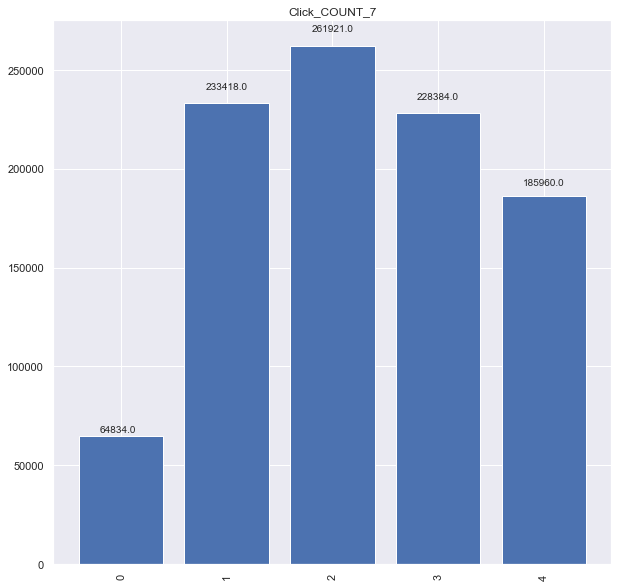

In [205]:
all_train_data_5=all_train_data["section"].value_counts().reset_index()
all_train_data_5.rename(columns={'index': 'sections',"section":'section_count'}, inplace=True)

all_train_data_5=all_train_data_5.sort_values(axis=0,by=['sections'],ascending=True)

plotcount(all_train_data_5,"sections","section_count",7)

plt.rcParams['figure.figsize'] = (10.0, 10.0) # 设置figure_size尺寸

In [ ]:

all_train_data_5.head()



In [ ]:
plotcount(all_train_data_5,"item_{0}".format(7),"click_count{}".format(7),7)

plt.rcParams['figure.figsize'] = (39.0, 4.0) # 设置figure_size尺寸

#### 用户和商品点击次数出现的个数

In [29]:
shape_item_num=[]
for i in range(5,14):
    col="time_top_{0}".format(i)
 
    item_col_count=col+"_item_clickcount"
   
    shape_item_num.append(train_click[item_col_count].drop_duplicates().shape[0])
shape_item_num

[208, 165, 137, 83, 39, 14, 7, 4, 3]

In [30]:
shape_user_num=[]
for i in range(5,14):
    col="time_top_{0}".format(i)
 
    user_col_count=col+"_user_clickcount"
   
    shape_user_num.append(train_click[user_col_count].drop_duplicates().shape[0])
shape_user_num

[218, 155, 94, 56, 25, 8, 4, 4, 3]

In [31]:
train_click['time_top_5_item_clickcount'].value_counts().to_frame()

,time_top_5_item_clickcount
4,90768
8,65640
5,63535
7,59164
6,57240
9,55746
10,50400
3,48249
11,41855
12,37992


#### user_id、time_top_n、time_top_5_user_clickcount之间关系

In [32]:
train_click_item5= train_click[['user_id','time_top_5_user_clickcount','time_top_5']]

train_click_item5[train_click_item5["user_id"]==1].head()

,user_id,time_top_5_user_clickcount,time_top_5
0,1,14,0.983
1,1,14,0.983
2,1,14,0.983
3,1,14,0.983
4,1,14,0.983


In [33]:
train_click.columns

Index(['user_id', 'item_id', 'time', 'time_top_5', 'time_top_6', 'time_top_7',
       'time_top_8', 'time_top_9', 'time_top_10', 'time_top_11', 'time_top_12',
       'time_top_13', 'time_top_5_user_clickcount',
       'time_top_6_user_clickcount', 'time_top_7_user_clickcount',
       'time_top_8_user_clickcount', 'time_top_9_user_clickcount',
       'time_top_10_user_clickcount', 'time_top_11_user_clickcount',
       'time_top_12_user_clickcount', 'time_top_13_user_clickcount',
       'time_top_5_item_clickcount', 'time_top_6_item_clickcount',
       'time_top_7_item_clickcount', 'time_top_8_item_clickcount',
       'time_top_9_item_clickcount', 'time_top_10_item_clickcount',
       'time_top_11_item_clickcount', 'time_top_12_item_clickcount',
       'time_top_13_item_clickcount'],
      dtype='object')

In [37]:
item_top5_count=train_click[['item_id','time_top_5_item_clickcount','time_top_5']]
item_top5_count.head()
item_top5_count['time_top_5'].drop_duplicates()

,item_id,time_top_5_item_clickcount,time_top_5
0,78142,32,0.983
1,26646,4,0.983
2,89568,24,0.983
3,76240,9,0.983
4,87533,3,0.983


0     0.983
14    0.984
Name: time_top_5, dtype: object

In [38]:
train_click_item5.columns

Index(['user_id', 'time_top_5_user_clickcount', 'time_top_5'], dtype='object')

In [41]:
train_click_item5=train_click_item5[train_click_item5["time_top_5_user_clickcount"]==1]
train_click_item5.head()

,user_id,time_top_5_user_clickcount,time_top_5
352,11,1,0.984
358,12,1,0.984
399,14,1,0.984
437,18,1,0.983
1387,52,1,0.983


In [42]:
train_click['time_top_6_item_clickcount'].value_counts().to_frame().head()

,time_top_6_item_clickcount
2,150738
3,120828
4,113292
1,92126
6,85746


In [43]:
train_click['time_top_7_item_clickcount'].value_counts().to_frame().head()

,time_top_7_item_clickcount
1,381013
2,357446
4,92156
3,65913
6,24288


In [44]:
train_click['time_top_8_item_clickcount'].value_counts().to_frame().head()

,time_top_8_item_clickcount
1,542851
2,402984
4,21696
3,13983
6,2790


### 读取用户数据

In [45]:
train_user_data=getTrainData(train_path_user,isckick=False,names=['user_id', 'user_age_level', 'user_gender','user_city_level'])

In [46]:
train_user_data.head()
train_user_data.info()
train_user_data.describe()
train_user_data.shape[0]

,user_id,user_age_level,user_gender,user_city_level
0,17,8.0,M,4.0
1,26,7.0,M,2.0
2,35,6.0,F,4.0
3,40,6.0,M,1.0
4,49,6.0,M,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6789 entries, 0 to 6788
Data columns (total 4 columns):
user_id            6789 non-null int64
user_age_level     6706 non-null float64
user_gender        6708 non-null object
user_city_level    6767 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 212.2+ KB


,user_id,user_age_level,user_city_level
count,6789.000000,6706.000000,6767.000000
mean,17247.432170,4.535789,3.708438
std,10062.597713,1.803134,1.798518
min,10.000000,1.000000,1.000000
25%,8637.000000,3.000000,2.000000
50%,17196.000000,5.000000,3.000000
75%,25856.000000,6.000000,6.000000
max,35432.000000,8.000000,6.000000


6789

In [47]:
train_user_data_gruopvy_Level=train_user_data["user_city_level"].value_counts().to_frame()

### 城市等级分布

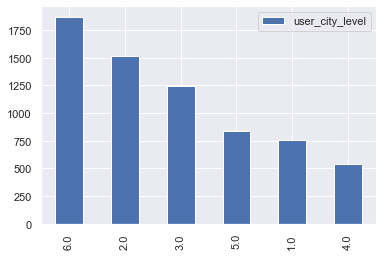

In [48]:
train_user_data_gruopvy_Level.plot(kind='bar')

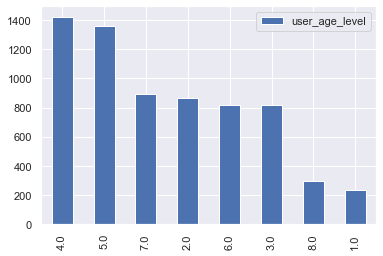

In [49]:
train_user_data_gruopvy_agelevel=train_user_data["user_age_level"].value_counts().to_frame()
train_user_data_gruopvy_agelevel.plot(kind='bar')

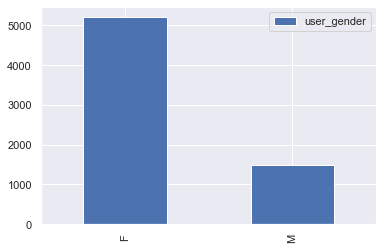

In [50]:
train_user_data_gruopvy_gender=train_user_data["user_gender"].value_counts().to_frame()
train_user_data_gruopvy_gender.plot(kind='bar')

## 性别和城市等级直接的柱状体

In [51]:
train_user_data_gruop_genandcity= train_user_data.groupby(["user_gender","user_city_level"]).size().reset_index()
train_user_data_gruop_genandcity.rename(columns={0:"count"},inplace=True)

In [52]:
train_user_data_gruop_genandcity

,user_gender,user_city_level,count
0,F,1.0,560
1,F,2.0,1200
2,F,3.0,932
3,F,4.0,418
4,F,5.0,650
5,F,6.0,1433
6,M,1.0,189
7,M,2.0,295
8,M,3.0,295
9,M,4.0,113


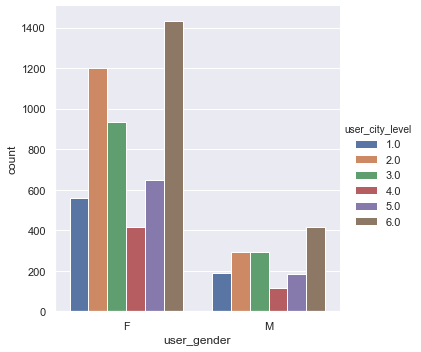

In [53]:
sns.catplot(x="user_gender", y="count", hue="user_city_level", kind="bar", data=train_user_data_gruop_genandcity);

### 找出性别的年龄分布

In [54]:
train_user_data_gruop_genandage= train_user_data.groupby(["user_gender","user_age_level"]).size().reset_index()
train_user_data_gruop_genandage.rename(columns={0:"count"},inplace=True)

In [55]:
train_user_data_gruop_genandage

,user_gender,user_age_level,count
0,F,1.0,188
1,F,2.0,712
2,F,3.0,693
3,F,4.0,1153
4,F,5.0,1051
5,F,6.0,580
6,F,7.0,632
7,F,8.0,200
8,M,1.0,44
9,M,2.0,157


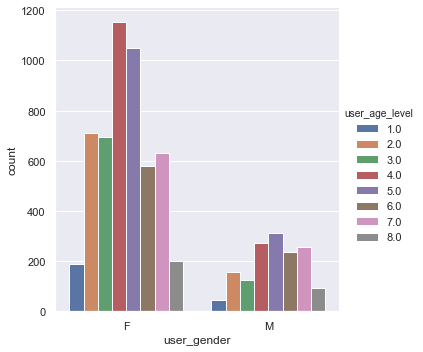

In [56]:
sns.catplot(x="user_gender", y="count", hue="user_age_level", kind="bar", data=train_user_data_gruop_genandage);

In [57]:
train_user_data.head()
train_user_data.shape[0]

,user_id,user_age_level,user_gender,user_city_level
0,17,8.0,M,4.0
1,26,7.0,M,2.0
2,35,6.0,F,4.0
3,40,6.0,M,1.0
4,49,6.0,M,1.0


6789

In [58]:
train_click.head()
train_click.shape[0]

,user_id,item_id,time,time_top_5,time_top_6,time_top_7,time_top_8,time_top_9,time_top_10,time_top_11,...,time_top_13_user_clickcount,time_top_5_item_clickcount,time_top_6_item_clickcount,time_top_7_item_clickcount,time_top_8_item_clickcount,time_top_9_item_clickcount,time_top_10_item_clickcount,time_top_11_item_clickcount,time_top_12_item_clickcount,time_top_13_item_clickcount
0,1,78142,0.983742,0.983,0.9837,0.98374,0.983741,0.9837416,0.98374161,0.983741619,...,1,32,1,1,1,1,1,1,1,1
1,1,26646,0.983757,0.983,0.9837,0.98375,0.983756,0.9837566,0.98375665,0.983756656,...,1,4,1,1,1,1,1,1,1,1
2,1,89568,0.983763,0.983,0.9837,0.98376,0.983763,0.9837634,0.98376343,0.983763437,...,1,24,3,2,1,1,1,1,1,1
3,1,76240,0.983770,0.983,0.9837,0.98377,0.983770,0.9837704,0.98377043,0.983770432,...,1,9,1,1,1,1,1,1,1,1
4,1,87533,0.983790,0.983,0.9837,0.98378,0.983789,0.9837895,0.98378950,0.983789507,...,1,3,1,1,1,1,1,1,1,1


1008258

In [59]:
train_userandclick= pd.merge(train_user_data,train_click,how='left', on=['user_id'])

In [60]:
train_userandclick.shape[0]
train_userandclick.head()

269429

,user_id,user_age_level,user_gender,user_city_level,item_id,time,time_top_5,time_top_6,time_top_7,time_top_8,...,time_top_13_user_clickcount,time_top_5_item_clickcount,time_top_6_item_clickcount,time_top_7_item_clickcount,time_top_8_item_clickcount,time_top_9_item_clickcount,time_top_10_item_clickcount,time_top_11_item_clickcount,time_top_12_item_clickcount,time_top_13_item_clickcount
0,17,8.0,M,4.0,55542,0.984143,0.984,0.9841,0.98414,0.984142,...,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,17,8.0,M,4.0,79153,0.984210,0.984,0.9842,0.98420,0.984209,...,1.0,7.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
2,17,8.0,M,4.0,18679,0.984210,0.984,0.9842,0.98421,0.984210,...,1.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,17,8.0,M,4.0,35758,0.984211,0.984,0.9842,0.98421,0.984211,...,1.0,50.0,11.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0
4,17,8.0,M,4.0,62109,0.984211,0.984,0.9842,0.98421,0.984211,...,1.0,12.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### 查看性别年龄和物品见关系

In [61]:
train_sex_item=train_userandclick.groupby(["item_id","user_gender"]).size().to_frame()

In [62]:
train_userandclick["user_gender"].value_counts().to_frame().reset_index()

,index,user_gender
0,F,233743
1,M,33825


### 女性和物品之间关联

In [63]:
train_userandclick_f=train_userandclick[train_userandclick["user_gender"]=='F']
train_userandclick_f.shape[0]

train_userandclick_f_time_top_5 =train_userandclick_f[['item_id','time_top_5_item_clickcount','time_top_5']]


233743

In [64]:
t=train_userandclick_f[['item_id','time_top_5_item_clickcount','time_top_5','user_id']]
tt_984=t[(t["item_id"]==52766) &(t["time_top_5"]=='0.984')].drop_duplicates()
tt_983=t[(t["item_id"]==52766) &(t["time_top_5"]=='0.983')].drop_duplicates()

In [65]:
tt_984.head()
tt_984.shape
tt_983.head()
tt_983.shape

,item_id,time_top_5_item_clickcount,time_top_5,user_id
6771,52766,438.0,0.984,1463
10093,52766,438.0,0.984,2471
19685,52766,438.0,0.984,4294
21346,52766,438.0,0.984,4740
22514,52766,438.0,0.984,5080


(71, 4)

,item_id,time_top_5_item_clickcount,time_top_5,user_id
13230,52766,434.0,0.983,3085
19880,52766,434.0,0.983,4328
22924,52766,434.0,0.983,5188
26443,52766,434.0,0.983,6110
27982,52766,434.0,0.983,6602


(68, 4)

In [66]:
tt_984[tt_984["user_id"].isin(tt_983["user_id"])]["user_id"].drop_duplicates().shape

(17,)

In [67]:
train_userandclick_f_time_top_5=train_userandclick_f_time_top_5.drop_duplicates()

In [68]:
train_userandclick_f_time_top_5=train_userandclick_f_time_top_5.sort_values(axis=0,by=['time_top_5_item_clickcount'],ascending=False).reset_index()

In [69]:
train_userandclick_f_time_top_5_50=train_userandclick_f_time_top_5.loc[0:10,:]

In [70]:
z=train_userandclick_f_time_top_5["item_id"].value_counts().to_frame().reset_index()

In [71]:
z=z[z["item_id"]==2][["index"]]

In [72]:
train_userandclick_f_time_top_5_item2=train_userandclick_f_time_top_5[train_userandclick_f_time_top_5["item_id"].isin(z["index"])]

In [74]:
train_userandclick_f_time_top_5_item2[train_userandclick_f_time_top_5_item2["time_top_5_item_clickcount"]>200]
train_userandclick_f_time_top_5.head()

,index,item_id,time_top_5_item_clickcount,time_top_5
0,6771,52766,438.0,0.984
1,13230,52766,434.0,0.983
2,9880,111225,357.0,0.984
3,3843,13302,331.0,0.984
4,306,4340,312.0,0.984
5,666,4230,296.0,0.984
6,8751,87254,286.0,0.983
7,751,2420,273.0,0.983
8,17354,21426,253.0,0.984
9,1869,80227,249.0,0.983


,index,item_id,time_top_5_item_clickcount,time_top_5
0,6771,52766,438.0,0.984
1,13230,52766,434.0,0.983
2,9880,111225,357.0,0.984
3,3843,13302,331.0,0.984
4,306,4340,312.0,0.984


In [ ]:
train_userandclick_f_time_top_5_item2.describe()

In [ ]:

sns.catplot(x="item_id", y="time_top_5_item_clickcount", hue="time_top_5", kind="bar",size=10, data=train_userandclick_f_time_top_5_50);

In [ ]:
item_count=train_userandclick_f["item_id"].value_counts().reset_index()
item_count.columns=["item_id","item_id_count"]
item_count.info()

## 获取测试数据集

In [ ]:
test_click_data=getTrainData(test_path_click,isckick=True,names=['user_id', 'item_id', 'time'],num=6)

In [ ]:
test_click_data.head()
test_click_data.info()
test_click_data.shape[0]

In [ ]:
test_click_data_qtime=getTrainData(test_path_click_qtime,isckick=True,names=['user_id', 'query_time'],num=6)

In [ ]:
test_click_data_qtime.head()
test_click_data_qtime.info()
test_click_data_qtime.shape[0]


In [ ]:
item_feat_train=pd.read_csv(train_path_item, header=None)

In [ ]:
item_feat_train_image=item_feat_train.loc[:,129:257]

In [ ]:
item_feat_train_image.columns

In [ ]:
item_feat_train_image.head()

In [ ]:
item_feat_train_image[129]=item_feat_train_image[129].apply(lambda x: x[1:])

In [ ]:
item_feat_train_image[256]=item_feat_train_image[256].apply(lambda x: x[:-1])

In [ ]:
item_feat_train_image.head()

In [ ]:
import matplotlib.pyplot as pyplot 


In [ ]:
oneimg=item_feat_train_image.loc[1,:].values.reshape((8, 16)).astype(np.float)
pyplot.imshow(oneimg)

In [ ]:
oneimg_2=item_feat_train_image.loc[2,:].values.reshape((8, 16)).astype(np.float)
pyplot.imshow(oneimg_2)